In [1]:
import torch
import numpy as np
import argparse
import imutils
import time
import cv2

from PIL import Image, ImageOps, ImageFont, ImageDraw
from torchvision import transforms

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
import torch.nn as nn

import models.MathNet as mnt
import models.MathNet56 as mnt56
from models.MathNetFactory import MathNetFactory
from SlidingWindow import *

In [2]:
IMAGE_SIZE = 56

NUM_CLASSES = mnt.NUM_CLASSES
factory = MathNetFactory()
factory.SetModel(IMAGE_SIZE)


In [3]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=12, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=3, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, NUM_CLASSES)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [5]:
class Letter:
    def __init__(self, x, y, w, h, img):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.image = img
        
        self.line = 0
        
        self.bottom = self.y + self.height
        self.top = self.y
        self.left = self.x
        self.right = self.x + self.width

        self.value = 'None'
        
    def resize():
        pass

In [6]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=16,
    ROI_SIZE=(10, 10),
    INPUT_SIZE=(32, 32),
    VISUALIZE=True,
    MIN_CONF=3.05,
    IMAGE_SIZE=IMAGE_SIZE,
    DEBUG=True
)

70.73684210526316 66.52631578947368
regions_of_interest =  1566
1566
found letters =  49
F


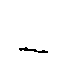

v


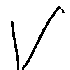

4


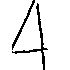

x


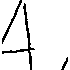

4


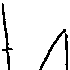

4


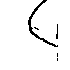

4


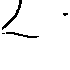

not


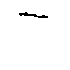

not


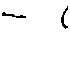

γ


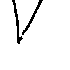

y


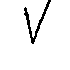

y


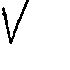

not


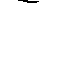

γ


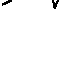

6


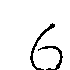

6


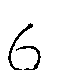

not


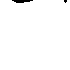

not


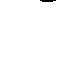

not


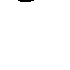

F


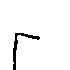

x


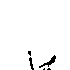

x


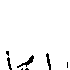

1


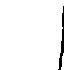

F


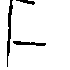

x


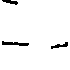

7


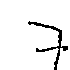

7


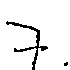

x


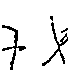

x


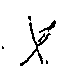

4


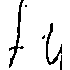

4


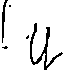

ω


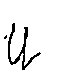

not


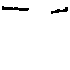

y


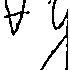

y


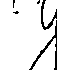

not


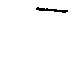

not


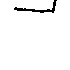

0


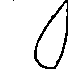

0


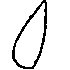

y


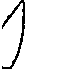

y


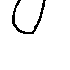

A


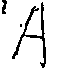

4


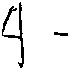

→


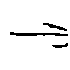

y


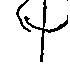

y


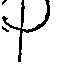

not


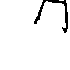

not


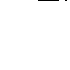

not


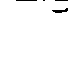

END


In [17]:
sw = SlidingWindow(factory.LoadModel(), kwargs)
IMAGE_NAME = 'TEST//real5.jpg'
image = cv2.imread(IMAGE_NAME)
output = sw(image)

letters = output[1]
for letter in letters:
    letter_image = Image.fromarray(letter.image.astype('uint8'))
    print(letter.value)
    display(letter_image)
print('END')



In [8]:
def resize_image(image, dst):
#     # соотношение сторон: ширина, делённая на ширину оригинала
#     ratio = float(dwt / image.shape[1])
#     print(ratio)
#     # желаемая высота: высота, умноженная на соотношение сторон
#     dht = int(image.shape[0] * ratio)
#     print(image.shape[0] * ratio)
#     dim = (dwt, dht)  # итоговые размеры
#     print(dim)
    # Масштабируем картинку
    # Подготовим новые размеры
    x = float(dst) / image.shape[1]
    y = float(dst) / image.shape[0]
    # уменьшаем изображение до подготовленных размеров
    return cv2.resize(image, (0,0), fx=x,fy=y, interpolation = cv2.INTER_AREA)

In [9]:
class Letter:
    def __init__(self, x, y, w, h, img):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.image = img
        
        self.line = 0
        
        self.bottom = self.y + self.height
        self.top = self.y
        self.left = self.x
        self.right = self.x + self.width

In [10]:
def letters_extract(image_file):
    img = cv2.imread(image_file)
    output = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #set a thresh
    thresh = 100
    ret, thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    img_erode = thresh_img#cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=3)
#     cv2.imshow('MyPhoto', img_erode)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('MyPhoto', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 1 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
    cv2.imshow('result', result )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('img_contours', img_contours )
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        
        x,y,w,h = cv2.boundingRect(contour)
        rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        cv2.imshow('inverted', inverted )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    return letters, output

In [11]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [12]:
def img_to_str(model, image_file):
    letters, output = letters_extract(image_file)   
    output = Image.fromarray(output.astype('uint8'))
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    s_out = ""
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    print()
    for i in range(len(letters)):
        img = Image.fromarray(letters[i].image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
            transforms.Grayscale(1),
            transforms.ToTensor()

        ])        
        x_image = convert_tensor(img)
        aaa = transforms.ToPILImage()
        display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        pred_arg_max = pred.argmax().item()
        mapped = mnt.map_pred(pred_arg_max)
        
        #cv2.putText(output, mapped+' '+"{:.2f}".format(pred.max().item()), (letters[i].x, letters[i].y), cv2.FONT_HERSHEY_COMPLEX, 0.45, (0, 0, 0), 1)

        # Draw non-ascii text onto image
        font = ImageFont.truetype("ARIALUNI.TTF", 24, encoding="unic")
        draw = ImageDraw.Draw(output)
        draw.text((letters[i].x, letters[i].y), mapped+' '+"{:.2f}".format(pred.max().item()), font=font)
        
        x = letters[i].x
        y = letters[i].y
        size = (letters[i].width, letters[i].height)
        if (letters[i].line >  prev_line):
            s_out += "\n"
            prev_line = letters[i].line
        prev_loc, prev_size = (x,y), size
        s_out += mapped + ' '
        print(letters[i].image.shape, "{:.2f}".format(pred.max().item()), mapped)
    #output = Image.fromarray(output.astype('uint8'))
    display(output)
    return s_out

In [13]:
model = factory.LoadModel()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

EVALUATION


In [14]:
# s = img_to_str(model, 'TEST/5.jpg')
# print('RESULT:')
# print(s)

In [15]:
def abracadabra():
    img = cv2.imread('TEST/real1.jpg')
    cv2.imshow('MyPhoto', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #set a thresh
    thresh = 100
    ret, thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.imshow('contours', resize_image(thresh_img, 224))
    #     cv2.waitKey()
    #     cv2.destroyAllWindows()

    output = img.copy()

    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('origin', resize_image(img, 224)) # выводим итоговое изображение в окно
    #cv2.imshow('gray', resize_image(gray, 224)) # выводим итоговое изображение в окно
    cv2.imshow('res', resize_image(img_contours, 224)) # выводим итоговое изображение в окно

    cv2.waitKey()
    cv2.destroyAllWindows()
